In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.base import clone
from itertools import combinations
import pickle
from sklearn.linear_model  import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

---

# 切訓練集和測試集
訓練: 2018-2021
測試: 2022

In [308]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

---

# 界外值處理

### 檢視連續變數中，在Q3+1.5IQR及Q1-1.5IQR之外的特徵
-氣溫(℃)、測站氣壓(hPa)、相對溼度(%)_x、降水量(mm)_x、風速(m/s)_x、population_density、流量加權

In [200]:
for feature in df.columns:
    data = df[f'{feature}']
    
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = Q3 - Q1
    
    up_bound = Q3 + 1.5*IQR;   down_bound = Q1 - 1.5*IQR
    up_mask = data > up_bound; down_mask = data < down_bound
    out_mask = up_mask|down_mask
    
    print(f'{feature}的outlier有: ',data[out_mask].shape[0], '筆')

dow的outlier有:  0 筆
doy的outlier有:  0 筆
元旦的outlier有:  22149 筆
春節的outlier有:  63128 筆
二二八的outlier有:  24142 筆
兒童清明的outlier有:  36240 筆
端午的outlier有:  27011 筆
中秋的outlier有:  30104 筆
雙十的outlier有:  24697 筆
發生年度的outlier有:  0 筆
發生月份的outlier有:  0 筆
發生日期的outlier有:  0 筆
發生時間的outlier有:  0 筆
經度的outlier有:  3432 筆
緯度的outlier有:  2 筆
氣溫(℃)_x的outlier有:  29270 筆
測站氣壓(hPa)_x的outlier有:  428730 筆
相對溼度(%)_x的outlier有:  59220 筆
降水量(mm)_x的outlier有:  325785 筆
風向(360degree)_x的outlier有:  0 筆
風速(m/s)_x的outlier有:  158937 筆
population_density的outlier有:  427833 筆
流量加權的outlier有:  142498 筆
車禍發生的outlier有:  0 筆


### 有界外值的特徵的盒鬚圖
-氣溫(℃)、測站氣壓(hPa)、相對溼度(%)_x、降水量(mm)_x、風速(m/s)_x、population_density、流量加權

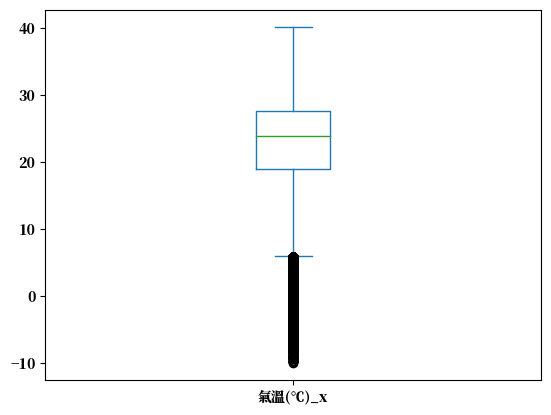

氣溫(℃)_x的outlier有:  29270 筆


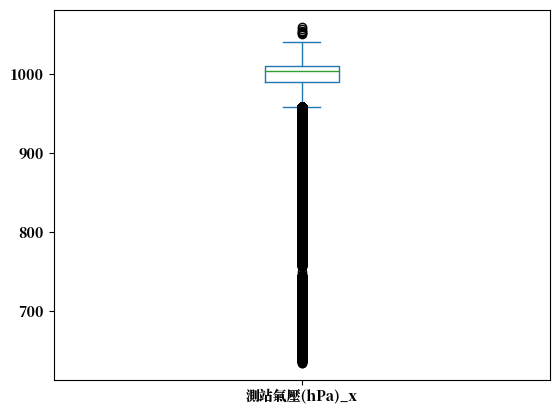

測站氣壓(hPa)_x的outlier有:  428730 筆


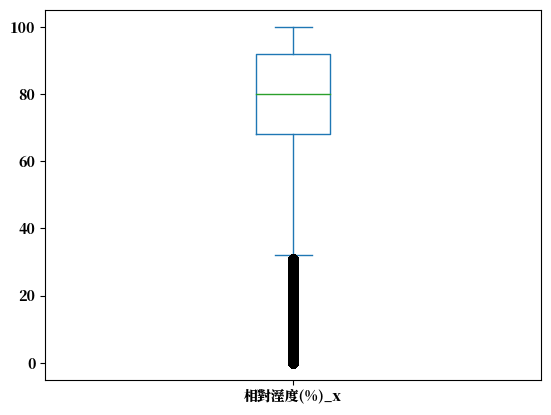

相對溼度(%)_x的outlier有:  59220 筆


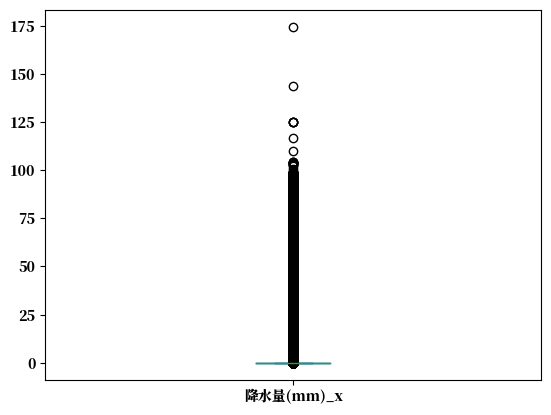

降水量(mm)_x的outlier有:  325785 筆
風向(360degree)_x的outlier有:  0 筆


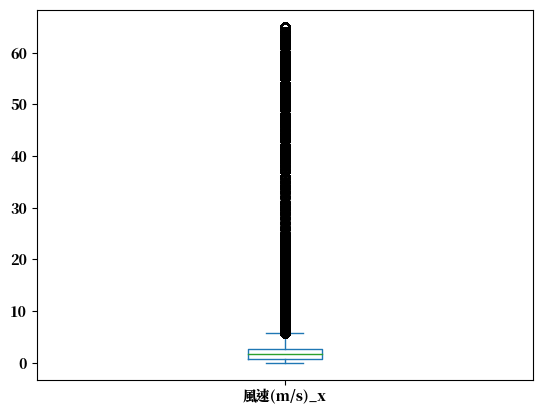

風速(m/s)_x的outlier有:  158937 筆


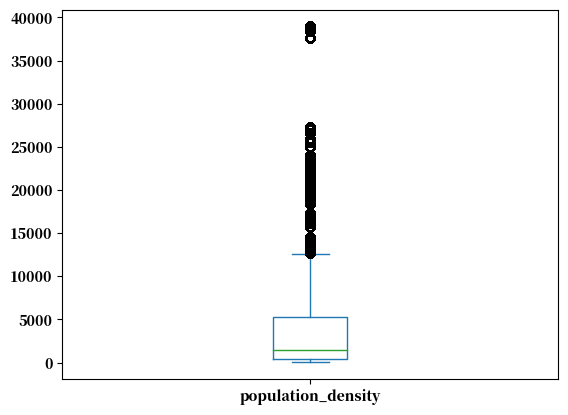

population_density的outlier有:  427833 筆


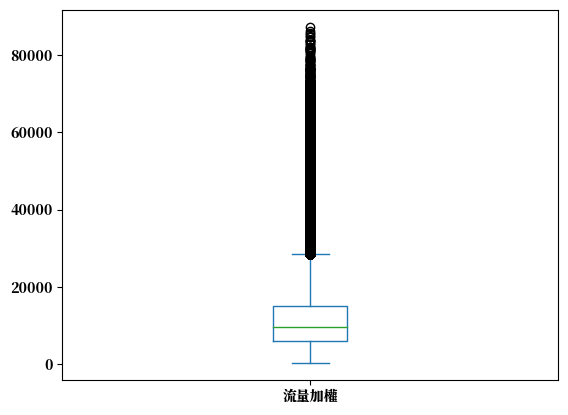

流量加權的outlier有:  142498 筆


In [201]:
for feature in df.columns[-9:-1]:
    data = df[f'{feature}']
    
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = Q3 - Q1
    
    up_bound = Q3 + 1.5*IQR;   down_bound = Q1 - 1.5*IQR
    up_mask = data > up_bound; down_mask = data < down_bound
    out_mask = up_mask|down_mask
    
    if outlier_num:=(df[out_mask].shape[0]):
        data.plot.box()
        plt.show()
    
    
    print(f'{feature}的outlier有: ',data[out_mask].shape[0],'筆')

### 清除界外值

先看刪掉所有界外值後的表

In [202]:
df_noOutlier = df
eliminate_mask = pd.Series
eliminate_sum = 0
for feature in df_noOutlier.columns[-9:-1]:
    
    data = df_noOutlier[f'{feature}']
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = Q3 - Q1
    up_bound = Q3 + 1.5*IQR
    down_bound = Q1 - 1.5*IQR
    up_mask = data > up_bound
    down_mask = data < down_bound
    out_mask = up_mask|down_mask
    in_mask =  ~out_mask

    if outlier_num:=(df_noOutlier[out_mask].shape[0]):
        if eliminate_mask.shape != out_mask.shape:
            eliminate_mask = out_mask
        else:
            eliminate_mask = eliminate_mask | out_mask
        
        eliminate_sum += outlier_num
        print(f'{feature}界外值:\t\t{outlier_num}筆')
    # df_noOutlier = df_noOutlier[in_mask]
print(f'共需刪除{eliminate_mask.sum()}筆')
df_noOutlier = df_noOutlier[~eliminate_mask]
df_noOutlier

氣溫(℃)_x界外值:		29270筆
測站氣壓(hPa)_x界外值:		428730筆
相對溼度(%)_x界外值:		59220筆
降水量(mm)_x界外值:		325785筆
風速(m/s)_x界外值:		158937筆
population_density界外值:		427833筆
流量加權界外值:		142498筆
共需刪除1163926筆


,dow,doy,元旦,春節,二二八,兒童清明,端午,中秋,雙十,發生年度,...,緯度,氣溫(℃)_x,測站氣壓(hPa)_x,相對溼度(%)_x,降水量(mm)_x,風向(360degree)_x,風速(m/s)_x,population_density,流量加權,車禍發生
0,0,1,1,0,0,0,0,0,0,2018,...,22.999773,14.4,1012.0,99.0,0.0,137.0,0.5,6009,26664.974265,1
1,0,1,1,0,0,0,0,0,0,2018,...,23.026156,17.8,1017.8,84.0,0.0,22.0,2.0,1793,26813.457545,1
2,0,1,1,0,0,0,0,0,0,2018,...,23.061173,16.5,1017.2,90.0,0.0,7.0,0.8,765,22123.122152,1
4,0,1,1,0,0,0,0,0,0,2018,...,22.950055,16.7,1013.7,89.0,0.0,44.0,1.2,1226,16383.479745,1
5,0,1,1,0,0,0,0,0,0,2018,...,22.982599,17.1,1017.0,79.0,0.0,10.0,2.2,12423,20800.806298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658728,4,346,0,0,0,0,0,0,0,2020,...,23.292598,22.5,978.6,87.0,0.0,117.0,0.6,48,3179.354336,0
1658729,4,80,0,0,0,0,0,0,0,2020,...,24.367457,19.3,1011.0,99.0,0.0,0.0,0.0,216,6014.767306,0
1658730,3,108,0,0,0,0,0,0,0,2019,...,24.157554,27.8,1008.3,61.0,0.0,309.0,1.2,1663,2950.814879,0
1658731,3,63,0,0,0,0,0,0,0,2021,...,25.048201,16.2,1015.2,96.0,0.0,237.0,0.5,8510,4506.118148,0


再把原有界外值的特徵畫盒鬚圖

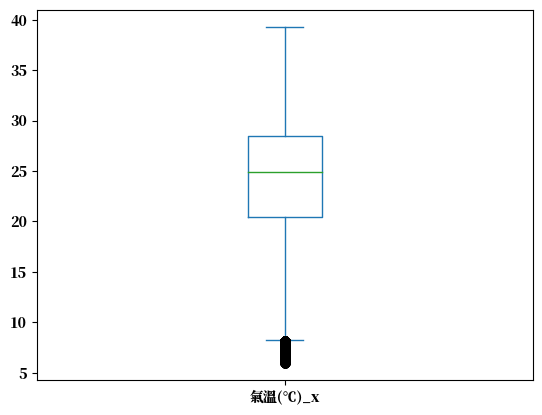

氣溫(℃)_x的outlier有:  3290 筆


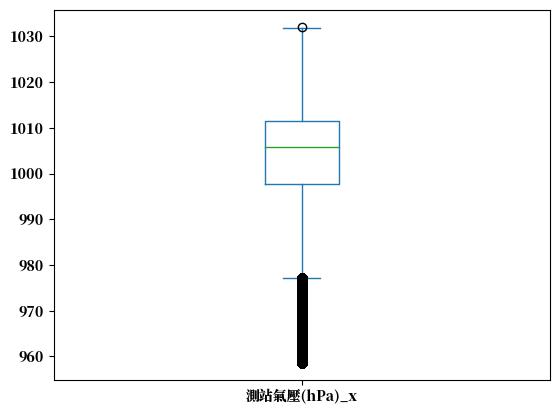

測站氣壓(hPa)_x的outlier有:  118729 筆


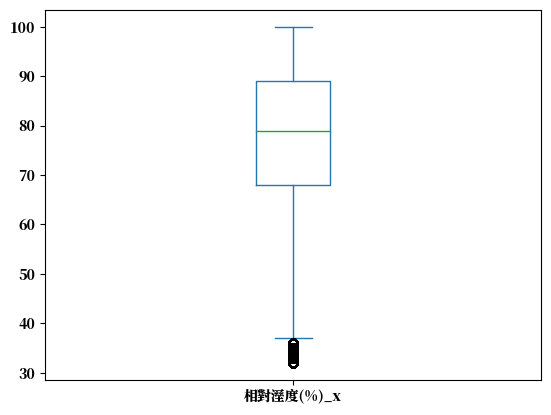

相對溼度(%)_x的outlier有:  4048 筆
降水量(mm)_x的outlier有:  0 筆
風向(360degree)_x的outlier有:  0 筆


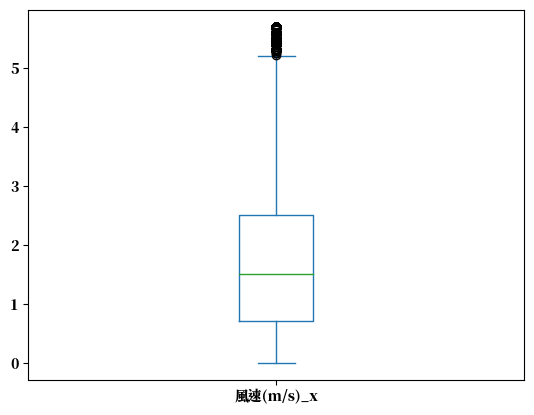

風速(m/s)_x的outlier有:  23842 筆


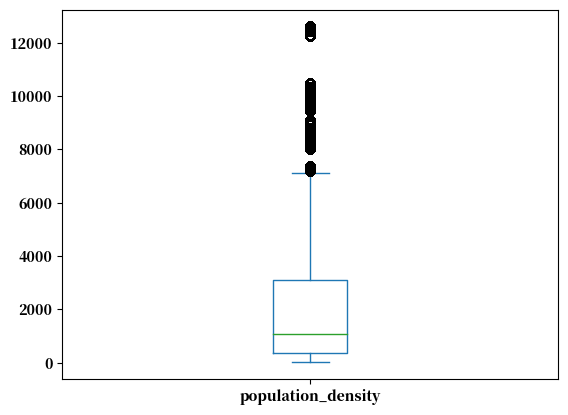

population_density的outlier有:  146210 筆


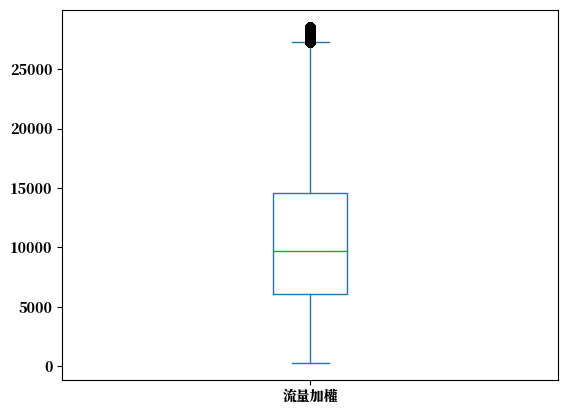

流量加權的outlier有:  14736 筆


In [203]:
for feature in df_noOutlier.columns[-9:-1]:
    data = df_noOutlier[f'{feature}']
    
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = Q3 - Q1
    
    up_bound = Q3 + 1.5*IQR;   down_bound = Q1 - 1.5*IQR
    up_mask = data > up_bound; down_mask = data < down_bound
    out_mask = up_mask|down_mask
    
    if outlier_num:=(df_noOutlier[out_mask].shape[0]):
        data.plot.box()
        plt.show()
    
    
    print(f'{feature}的outlier有: ',data[out_mask].shape[0],'筆')

#### 賦值給df

In [204]:
df = df_noOutlier

---

# 標準化

In [309]:
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

---

# 偏態

### 正負樣本一起看

#### 單純標準化，尚未log轉換前所有變數的偏態

In [310]:
def skew(column:pd.Series):
    return pd.Series([column.skew()], index=['偏態'])
    
skew_origin = df_std.apply(skew, axis=0).T
skew_origin

,偏態
dow,0.029521
doy,0.030481
元旦,12.130148
春節,7.049473
二二八,11.608060
兒童清明,9.421736
端午,10.959825
中秋,10.366772
雙十,11.473966
發生年度,0.012615


#### log轉換前，不看類別變數，只看量化變數的偏態的話，偏態大於4的特徵有
-氣壓、濕度、降水量、風速、人口密度、流量

In [311]:
skew_origin_above1 = skew_origin[abs(skew_origin.偏態)>1].iloc[7:]
skew_origin_above1

,偏態
測站氣壓(hPa)_x,-3.687313
相對溼度(%)_x,-1.424017
降水量(mm)_x,22.646024
風速(m/s)_x,8.270121
population_density,2.168261
流量加權,1.948368


In [124]:
plt.rcParams['font.sans-serif'] = ['Noto Serif TC']

-6.111139893983927 0.7964388614344692


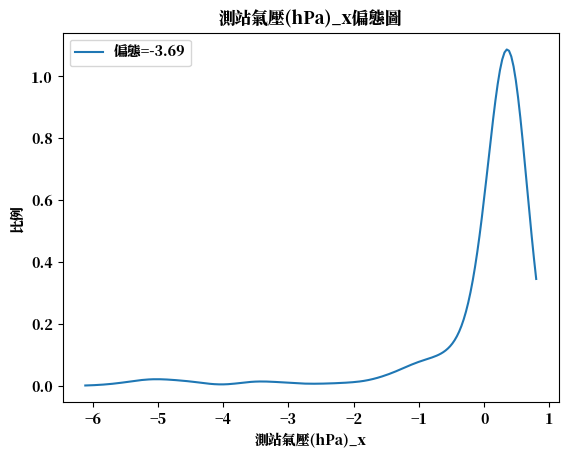

-4.484616679005151 1.2309141120496858


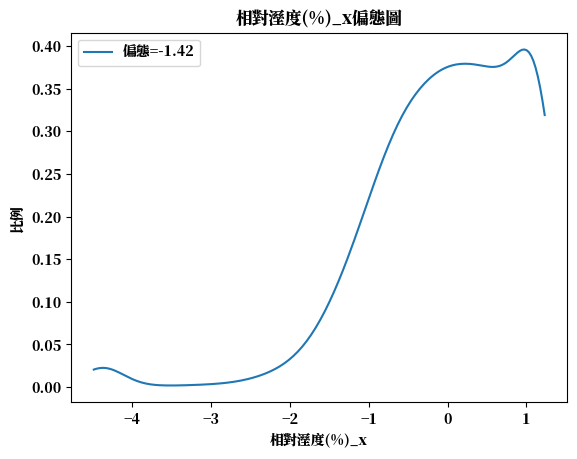

-0.11488318581796872 58.69695340874782


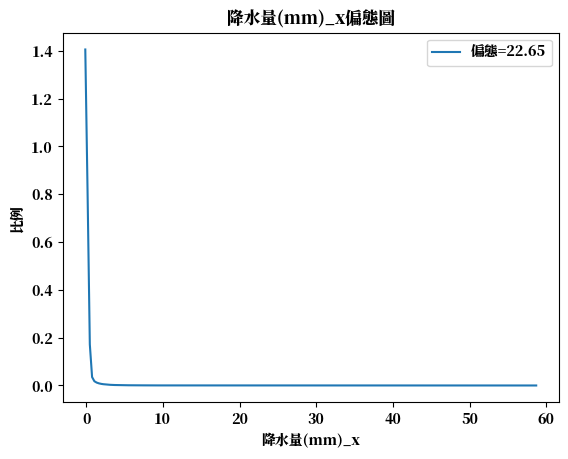

-0.39339260898729306 9.238970523434437


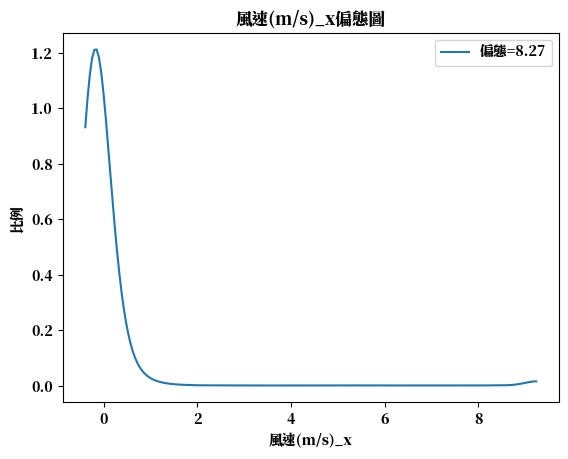

-0.6586494415972757 5.1206446353165065


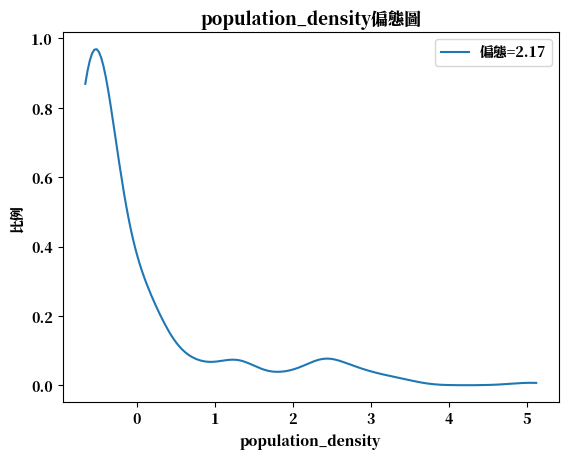

-1.3512837922944956 8.2285968895435


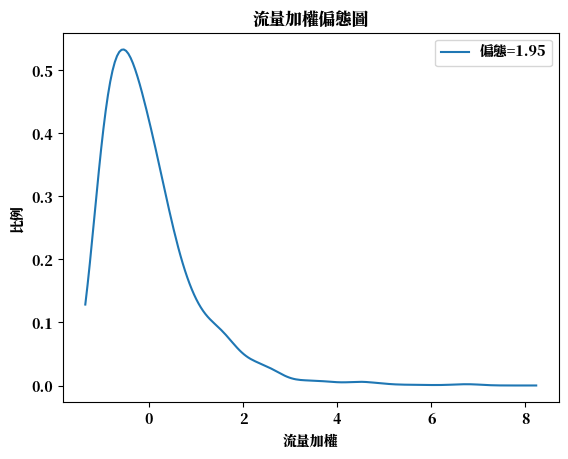

In [313]:
for feature in skew_origin_above1.index:

    data = df_std[feature].sample(100000)
    
    density = gaussian_kde(data)
    print(data.min(),data.max())
    xs = np.linspace(data.min(),data.max(),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    skew = skew_origin_above1.loc[feature, '偏態']
    plt.plot(xs,density(xs),label=f'偏態={skew:.2f}')

    plt.xlabel(f'{feature}')
    plt.ylabel(f'比例')
    plt.title(f'{feature}偏態圖')
    plt.legend()
    
    plt.show()

### log轉換
  [ '測站氣壓(hPa)_x', '相對溼度(%)_x', '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權']

In [314]:
class logData():
    def __init__(self):
        self.chose_to_log = [16,17,18,20,21,22]
        # [ '測站氣壓(hPa)_x', '相對溼度(%)_x', '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_log = X.copy()
        df_log = np.array(df_log)
        
        feature_log = df_log[:,self.chose_to_log].copy()
        feature_log[feature_log <= 0] = 1e-10
                
        # log轉換，合併回表中
        feature_log = np.log1p(feature_log)
        df_log[:,self.chose_to_log] = feature_log 
        
        return df_log   

In [315]:
log_scaler = logData().fit(df)
df_log = log_scaler.transform(df)
df_log = pd.DataFrame(df_log, columns=df.columns)
df_log

,dow,doy,元旦,春節,二二八,兒童清明,端午,中秋,雙十,發生年度,...,緯度,氣溫(℃)_x,測站氣壓(hPa)_x,相對溼度(%)_x,降水量(mm)_x,風向(360degree)_x,風速(m/s)_x,population_density,流量加權,車禍發生
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,...,22.999773,14.4,6.920672,4.605170,1.000000e-10,137.0,4.054651e-01,8.701180,10.191144,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,...,23.026156,17.8,6.926381,4.442651,1.000000e-10,22.0,1.098612e+00,7.492203,10.196696,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,...,23.061173,16.5,6.925792,4.510860,1.000000e-10,7.0,5.877867e-01,6.641182,10.004424,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,...,22.981113,17.1,6.925595,4.382027,1.000000e-10,10.0,1.163151e+00,9.541656,10.046764,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,...,22.950055,16.7,6.922348,4.499810,1.000000e-10,44.0,7.884574e-01,7.112327,9.704090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325305,4.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,...,24.367457,19.3,6.919684,4.605170,1.000000e-10,0.0,1.000000e-10,5.379897,8.702139,0.0
3325306,3.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,...,24.157554,27.8,6.917012,4.127134,1.000000e-10,309.0,7.884574e-01,7.416980,7.990175,0.0
3325307,3.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021.0,...,25.048201,16.2,6.923825,4.574711,1.000000e-10,237.0,4.054651e-01,9.049115,8.413413,0.0
3325308,2.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019.0,...,23.569772,22.7,6.919486,4.369448,1.000000e-10,50.0,6.931472e-01,5.828946,10.183151,0.0


### 正負樣本一起看

#### log轉換後所有變數的偏態

#### log轉換後再標準化

In [316]:
scaler = StandardScaler().fit(df_log)
df_log_std = pd.DataFrame(scaler.fit_transform(df_log),columns=df_log.columns)
df_log_std 

,dow,doy,元旦,春節,二二八,兒童清明,端午,中秋,雙十,發生年度,...,緯度,氣溫(℃)_x,測站氣壓(hPa)_x,相對溼度(%)_x,降水量(mm)_x,風向(360degree)_x,風速(m/s)_x,population_density,流量加權,車禍發生
0,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.098670,-1.421634,0.434540,0.617678,-0.242163,-0.109204,-0.883922,0.831335,1.488546,0.997644
1,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.067917,-0.865837,0.521916,0.265750,-0.242163,-1.049115,0.203110,0.183266,1.496274,0.997644
2,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.027100,-1.078348,0.512900,0.413452,-0.242163,-1.171712,-0.597996,-0.272921,1.228672,0.997644
3,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.120421,-0.980266,0.509893,0.134470,-0.242163,-1.147192,0.304323,1.281870,1.287600,0.997644
4,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.156623,-1.045654,0.460202,0.389524,-0.242163,-0.869306,-0.283293,-0.020365,0.810672,0.997644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325305,0.541571,-0.942533,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,0.027216,...,0.495554,-0.620633,0.419425,0.617678,-0.242163,-1.228924,-1.519796,-0.949030,-0.583829,-1.002361
3325306,0.033976,-0.675280,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-0.700384,...,0.250882,0.768860,0.378539,-0.417487,-0.242163,1.296576,-0.283293,0.142943,-1.574729,-1.002361
3325307,0.033976,-1.104793,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,0.754815,...,1.289054,-1.127389,0.482809,0.551720,-0.242163,0.708110,-0.883922,1.017845,-0.985673,-1.002361
3325308,-0.473618,-0.684825,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-0.700384,...,-0.434258,-0.064835,0.416400,0.107232,-0.242163,-0.820267,-0.432763,-0.708318,1.477422,-1.002361


#### log轉換後標準化，再檢視偏態
#### (看起來log轉換對於測站氣壓、濕度的偏態沒有幫助，但是對降水量、風速、人口密度、流量則有幫助)

In [317]:
def skew(column:pd.Series):
    return pd.Series([column.skew()], index=['偏態'])
    
skew_log = df_log_std .apply(skew, axis=0).T
skew_log
pd.concat([skew_origin, skew_log],axis=1,names=['log轉換前偏態','log轉換後偏態']).loc[['測站氣壓(hPa)_x', '相對溼度(%)_x', '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權'],:]

,偏態,偏態
測站氣壓(hPa)_x,-3.687313,-3.973347
相對溼度(%)_x,-1.424017,-6.035246
降水量(mm)_x,22.646024,5.713552
風速(m/s)_x,8.270121,1.444282
population_density,2.168261,-0.505224
流量加權,1.948368,-0.343655


### 只對降水量、風速、人口密度、流量做log，再做標準化

In [318]:
class logData():
    def __init__(self):
        self.chose_to_log = [18,20,21,22]
        # ['降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_log = X.copy()
        df_log = np.array(df_log)
        
        feature_log = df_log[:,self.chose_to_log].copy()
        feature_log[feature_log <= 0] = 1e-10
                
        # log轉換，合併回表中
        feature_log = np.log1p(feature_log)
        df_log[:,self.chose_to_log] = feature_log 
        
        return df_log   

In [319]:
log_scaler = logData().fit(df)
df_log = log_scaler.transform(df)
df_log = pd.DataFrame(df_log, columns=df.columns)

In [320]:
scaler = StandardScaler().fit(df_log)
df_log_std = pd.DataFrame(scaler.fit_transform(df_log),columns=df_log.columns)
df_log_std 

,dow,doy,元旦,春節,二二八,兒童清明,端午,中秋,雙十,發生年度,...,緯度,氣溫(℃)_x,測站氣壓(hPa)_x,相對溼度(%)_x,降水量(mm)_x,風向(360degree)_x,風速(m/s)_x,population_density,流量加權,車禍發生
0,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.098670,-1.421634,0.464327,1.173759,-0.242163,-0.109204,-0.883922,0.831335,1.488546,0.997644
1,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.067917,-0.865837,0.566245,0.316429,-0.242163,-1.049115,0.203110,0.183266,1.496274,0.997644
2,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.027100,-1.078348,0.555702,0.659361,-0.242163,-1.171712,-0.597996,-0.272921,1.228672,0.997644
3,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.120421,-0.980266,0.552187,0.030653,-0.242163,-1.147192,0.304323,1.281870,1.287600,0.997644
4,-1.488807,-1.696566,12.212029,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-1.427983,...,-1.156623,-1.045654,0.494199,0.602206,-0.242163,-0.869306,-0.283293,-0.020365,0.810672,0.997644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325305,0.541571,-0.942533,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,0.027216,...,0.495554,-0.620633,0.446755,1.173759,-0.242163,-1.228924,-1.519796,-0.949030,-0.583829,-1.002361
3325306,0.033976,-0.675280,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-0.700384,...,0.250882,0.768860,0.399310,-0.998143,-0.242163,1.296576,-0.283293,0.142943,-1.574729,-1.002361
3325307,0.033976,-1.104793,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,0.754815,...,1.289054,-1.127389,0.520557,1.002293,-0.242163,0.708110,-0.883922,1.017845,-0.985673,-1.002361
3325308,-0.473618,-0.684825,-0.081886,-0.13911,-0.085517,-0.104968,-0.090495,-0.095581,-0.086502,-0.700384,...,-0.434258,-0.064835,0.443240,-0.026503,-0.242163,-0.820267,-0.432763,-0.708318,1.477422,-1.002361


In [321]:
def skew(column:pd.Series):
    return pd.Series([column.skew()], index=['偏態'])
    
skew_log = df_log_std.apply(skew, axis=0).T
pre_after_skew = pd.concat([skew_origin, skew_log],axis=1).loc[['測站氣壓(hPa)_x', '相對溼度(%)_x', '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權'],:]
pre_after_skew.columns = ['log轉換前偏態','log轉換後偏態']
pre_after_skew

,log轉換前偏態,log轉換後偏態
測站氣壓(hPa)_x,-3.687313,-3.687313
相對溼度(%)_x,-1.424017,-1.424017
降水量(mm)_x,22.646024,5.713552
風速(m/s)_x,8.270121,1.444282
population_density,2.168261,-0.505224
流量加權,1.948368,-0.343655


### log轉換前後偏態視覺圖
[ '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權']

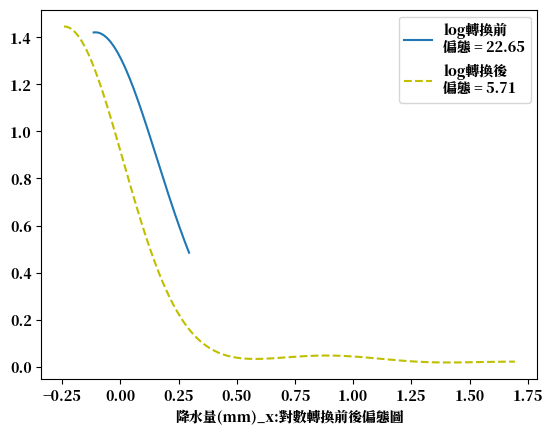

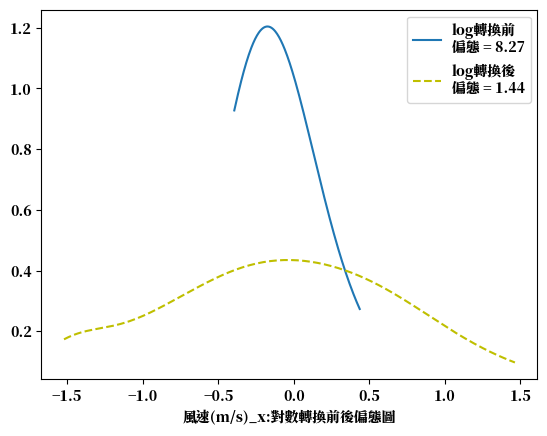

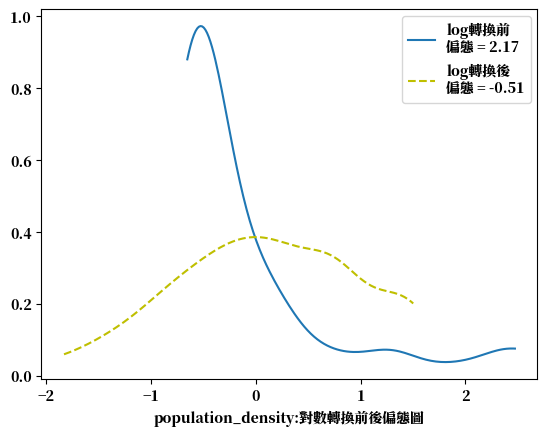

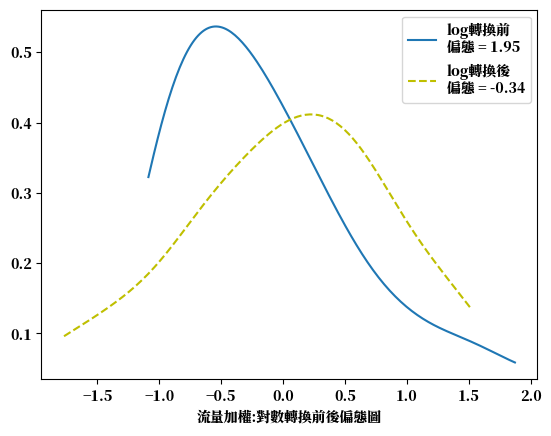

In [322]:
pre_after_skew = pre_after_skew.loc[[ '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權'],:]

for feature in pre_after_skew.index:

    data_origin = df_std[feature].sample(100000)
    data_log = df_log_std[feature].sample(100000)
    
    
    # 建立一張包含兩張子圖的圖表
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)

    # 定義 X 軸的數值區間（第一張圖的分布）
    x1 = np.linspace(np.quantile(data_origin, 0.05),np.quantile(data_origin, 0.95),200)
    density_origin = gaussian_kde(data_origin)

    # 定義 Y 軸的數值（第一張圖的分布）
    density_origin.covariance_factor = lambda : .25
    density_origin._compute_covariance()
    y1 = density_origin(x1)

    # 繪製第一張圖
    pre_skew = pre_after_skew.loc[feature, 'log轉換前偏態']
    ax.plot(x1, y1, label=f'log轉換前\n偏態 = {pre_skew:.2f}')
    
    # 標示圖例
    # fig.legend()

    # 建立第二張子圖
    # 定義 X 軸的數值區間（第二張圖的分布）
    x2 =  np.linspace(np.quantile(data_log, 0.05),np.quantile(data_log, 0.95),200)
    density_log = gaussian_kde(data_log)

    # 定義 Y 軸的數值（第二張圖的分布）
    density_log.covariance_factor = lambda : .25
    density_log._compute_covariance()
    y2 = density_log(x2)

    # 繪製第二張圖
    after_skew = pre_after_skew.loc[feature, 'log轉換後偏態']
    ax.plot(x2, y2, label = f'log轉換後\n偏態 = {after_skew:.2f}',linestyle='--',color='y')
    
    
    ax.legend()
    # 顯示圖表
    ax.set_xlabel(f'{feature}:對數轉換前後偏態圖')
    plt.show()

### 將log和標準化好的df作為分析用的df

In [323]:
df = df_log_std 

---

# 皮爾森績差相關
檢視連續變數x之間的相關性

多元共線性水準，取0.8以上(無符合)

In [324]:
pearson_cor = df.loc[:, df.columns[9:-1]].corr()
pearson_cor

,發生年度,發生月份,發生日期,發生時間,經度,緯度,氣溫(℃)_x,測站氣壓(hPa)_x,相對溼度(%)_x,降水量(mm)_x,風向(360degree)_x,風速(m/s)_x,population_density,流量加權
發生年度,1.000000,-0.087015,0.002084,-0.003197,0.024844,0.009051,0.021429,-0.001322,0.027085,0.006440,-0.024488,-0.037211,-0.011870,0.182712
發生月份,-0.087015,1.000000,0.010983,-0.000519,0.003719,0.004005,0.250874,-0.018005,-0.010923,0.021011,-0.035266,0.002012,0.001637,-0.010303
發生日期,0.002084,0.010983,1.000000,-0.002848,-0.012363,-0.011434,0.025665,-0.003297,0.013745,-0.002646,0.001746,-0.013753,-0.011066,-0.002002
發生時間,-0.003197,-0.000519,-0.002848,1.000000,0.011867,0.019646,0.084074,0.001791,-0.113172,0.022210,0.094897,0.107424,0.086941,0.006176
經度,0.024844,0.003719,-0.012363,0.011867,1.000000,0.748011,-0.193294,-0.161982,0.066643,0.075280,-0.161740,0.013121,0.082712,-0.085092
緯度,0.009051,0.004005,-0.011434,0.019646,0.748011,1.000000,-0.184888,-0.101332,0.013361,0.053275,-0.165252,0.055944,0.226582,-0.017170
氣溫(℃)_x,0.021429,0.250874,0.025665,0.084074,-0.193294,-0.184888,1.000000,0.428340,-0.279312,-0.092962,0.226015,-0.016419,0.085338,0.091301
測站氣壓(hPa)_x,-0.001322,-0.018005,-0.003297,0.001791,-0.161982,-0.101332,0.428340,1.000000,-0.091753,-0.052881,-0.021187,0.046043,0.174275,0.159427
相對溼度(%)_x,0.027085,-0.010923,0.013745,-0.113172,0.066643,0.013361,-0.279312,-0.091753,1.000000,0.193887,-0.171005,-0.407758,-0.133770,-0.031876
降水量(mm)_x,0.006440,0.021011,-0.002646,0.022210,0.075280,0.053275,-0.092962,-0.052881,0.193887,1.000000,-0.042372,0.041885,0.025008,-0.012157


In [325]:
def pearsonExamine(row: pd.Series):
    idx = row.name
    col = pearson_cor.columns[np.where(row>0.8)]
    col = col[col!=idx]
    if col.shape[0]:
        print(idx,col)
    
pearson_cor.apply(pearsonExamine, axis=1)

發生年度                  None
發生月份                  None
發生日期                  None
發生時間                  None
經度                    None
緯度                    None
氣溫(℃)_x               None
測站氣壓(hPa)_x           None
相對溼度(%)_x             None
降水量(mm)_x             None
風向(360degree)_x       None
風速(m/s)_x             None
population_density    None
流量加權                  None
dtype: object

### 熱度圖

<AxesSubplot: >

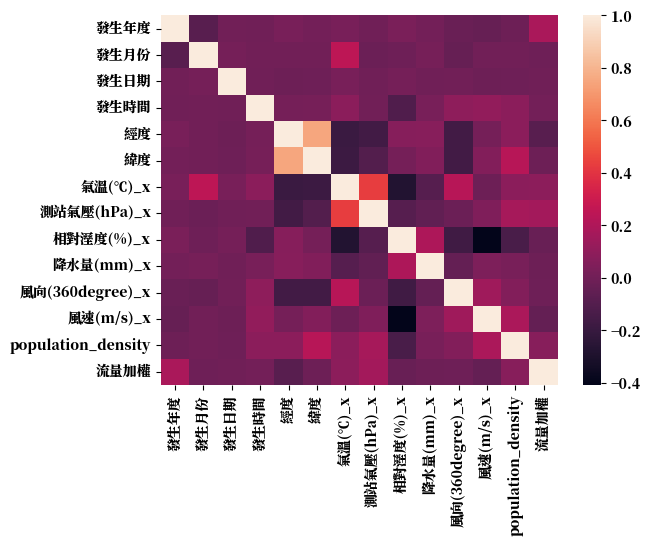

In [326]:
sns.heatmap(pearson_cor,
            xticklabels=pearson_cor.columns,
            yticklabels=pearson_cor.columns)

### VIF

In [244]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


x=df.drop(columns=['車禍發生'])
y=df['車禍發生']

vif=[variance_inflation_factor(x.values,x.columns.get_loc(i)) for i in x.columns]
list(zip(list(range(1,23)),vif))

KeyboardInterrupt: 

---

In [327]:
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

# 切出2022作為test set，2018-2021做為train set

---

# PCA

時間特徵Pca

In [328]:
pca = PCA()

# 分數矩陣
Timepca = pca.fit_transform(df.iloc[:,0:13]) 
print(Timepca.shape)

(3325310, 13)


In [329]:
# 負荷矩陣
# 前十個主成份與**15**個原始變數的關係
pca.components_[:10] # [:10] can be removed.
pca.components_[:10].shape # (10 components, 13 original variables)
type(pca.components_) # numpy.ndarray
print(pca.components_.shape )

(13, 13)


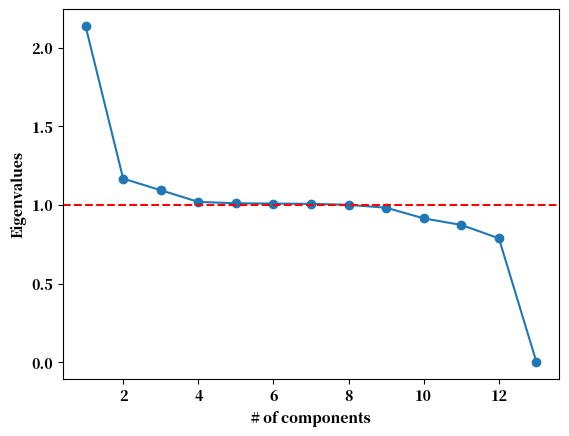

In [330]:
# 陡坡圖(scree plot 前段斜率絕對值大，但後段斜率降到很小！)決定取/看/用幾個主成份
pca.explained_variance_ratio_ # 15個主成份解釋的變異百分比
plt.plot(range(1, 14), pca.explained_variance_, '-o')
plt.xlabel('# of components')
plt.ylabel('Eigenvalues')
plt.axhline(y=1,color='r',linestyle='--')
plt.show()

# list(range(1,59))
# range(1,59).tolist() # AttributeError: 'range' object has no attribute 'tolist'

(3325310, 4)


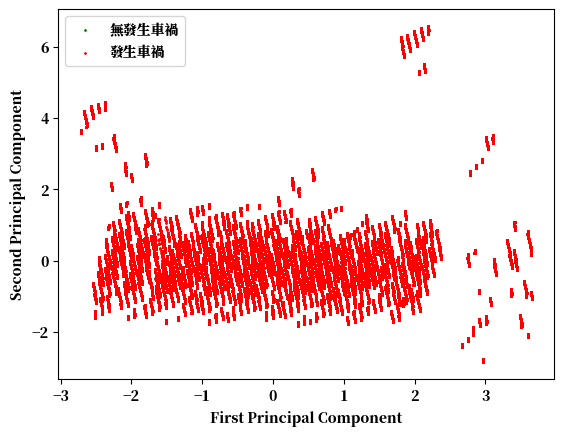

In [331]:
# type(teleXpca) # numpy.ndarray
# 可能可以降到**4維空間**中進行後續分析
Timepca = Timepca[:,:4]
print(Timepca.shape)

# PCA後可在頭兩個主成份空間中視覺化各樣本
scatter_x = Timepca[:,0]
scatter_y = Timepca[:,1]

group = df.車禍發生.apply(lambda x : 1 if x>0 else 0)
cdict = {1: 'red', 0: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = '發生車禍' if g else '無發生車禍', s = 1)
ax.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

天氣Pca

In [332]:
pca = PCA()

# 分數矩陣
Weatherpca = pca.fit_transform(df.iloc[:,15:21]) 
print(Weatherpca.shape)

(3325310, 6)


In [333]:
# 負荷矩陣
# 前十個主成份與**15**個原始變數的關係
pca.components_[:10] # [:10] can be removed.
pca.components_[:10].shape # (10 components, 13 original variables)
type(pca.components_) # numpy.ndarray
print(pca.components_.shape)

(6, 6)


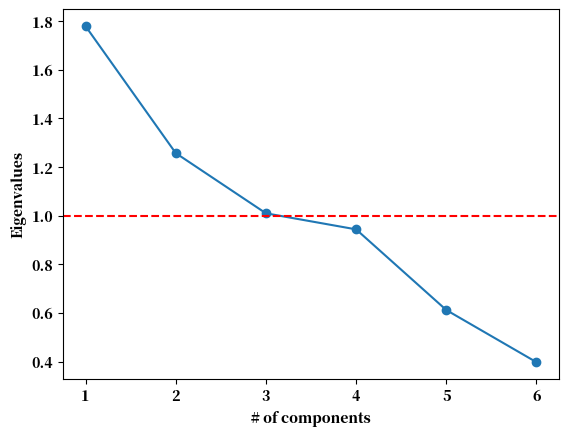

In [334]:
# 陡坡圖(scree plot 前段斜率絕對值大，但後段斜率降到很小！)決定取/看/用幾個主成份
pca.explained_variance_ratio_ # 6個主成份解釋的變異百分比
plt.plot(range(1, 7), pca.explained_variance_, '-o')
plt.xlabel('# of components')
plt.ylabel('Eigenvalues')
plt.axhline(y=1,color='r',linestyle='--')
plt.show()

(3325310, 3)


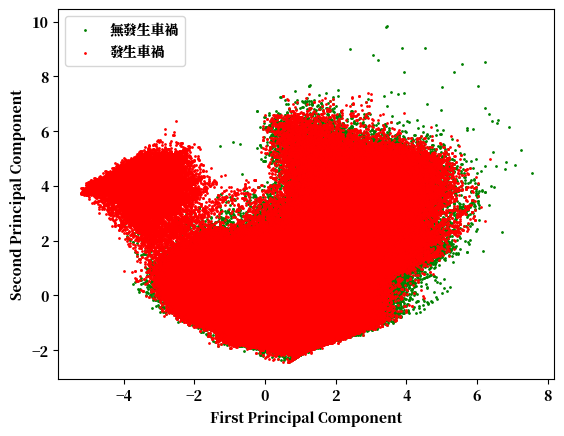

In [335]:
# type(teleXpca) # numpy.ndarray
# 可能可以降到**3維空間**中進行後續分析
Weatherpca = Weatherpca[:,:3]
print(Weatherpca.shape)

# PCA後可在頭兩個主成份空間中視覺化各樣本
scatter_x = Weatherpca[:,0]
scatter_y = Weatherpca[:,1]

group = df.車禍發生.apply(lambda x : 1 if x>0 else 0)
cdict = {1: 'red', 0: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = '發生車禍' if g else '無發生車禍', s = 1)
ax.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

---

# 小結

特徵工程處理流程:

1.
部分特徵有較嚴重的偏態，其中以下的特徵在做log轉換後可改善偏態。所以針對以下特徵做log轉換:
'降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權'

2.
所有特徵標準化

3.
無發現顯著特徵間的共線性，不處理

4.
後續機器學習若需做特徵縮減，可針對時間日期相關特徵、及天氣相關特徵分別做主成分分析。
其中，時間日期相關特徵的主成分分析，前四個主成分特徵值(解釋變異量)>1。天氣相關特徵的主成分分析，前三個主成分特徵值(解釋變異量)>1
故後續需做特徵縮減的機器學習，可依上方標準來取主成分做訓練

### 建立各項流程的類別，方便後續pipeline引用

In [2]:
# log轉換
class logData():
    def __init__(self):
        self.chose_to_log = [18,20,21,22]
        # [ '降水量(mm)_x','風速(m/s)_x', 'population_density', '流量加權']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_log = X.copy()
        df_log = np.array(df_log)
        
        feature_log = df_log[:,self.chose_to_log].copy()
        feature_log[feature_log <= 0] = 1e-10
                
        # log轉換，合併回表中
        feature_log = np.log1p(feature_log)
        df_log[:,self.chose_to_log] = feature_log 
        
        return df_log  

In [3]:
# 定義轉換器，該轉換器將會對每個特徵分組執行 PCA
class DateWeatherPCA():
    def __init__(self, time_components=4, weather_components=3):
        self.time_components = time_components
        self.weather_components = weather_components
        

    def fit(self, X, y=None):
        self.pca_time = PCA(n_components=self.time_components).fit(X[:,[i for i in range(13)]])
        self.pca_weather = PCA(n_components=self.weather_components).fit(X[:,[j for j in range(15,21)]])
        return self

    def transform(self, X):        
        # 將特徵分組
        # 0-12是時間，13、14是經緯度，15-20是天氣、21人口密度、22車流量
        time = self.pca_time.transform(X[:,[i for i in range(13)]])
        coord = X[:,[ 14, 15]]
        weather = self.pca_weather.transform(X[:,[j for j in range(15,21)]])
        density = X[:,[21]]
        stream = X[:,[22]]
        return np.concatenate([time, coord, weather, density, stream], axis=1)

---

###　機器學習模型選擇

-logis regression
-knn
-random forest
-adaboost
-xgboost

![jupyter](./參數調校.png)

---

# logis regression

In [336]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

In [361]:
pipe_logis = Pipeline([('log',logData()),
                       ('sc', StandardScaler()),
                       ('logis', LogisticRegression(n_jobs=6,))
                      ])

In [366]:
# 待估參數權重的字典
param_grid = {
    'logis__C':np.logspace(-4, 4, 30),
    'logis__penalty':['None','l1', 'l2','elasticnet'],
}

In [367]:
# 建立GridSearchCV空模
logis_grid = GridSearchCV(estimator=pipe_logis, 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='accuracy', 
                        verbose=10)


logis_grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START logis__C=0.0001, logis__penalty=None......................
[CV 1/5; 1/120] END logis__C=0.0001, logis__penalty=None;, score=nan total time=   1.2s
[CV 2/5; 1/120] START logis__C=0.0001, logis__penalty=None......................
[CV 2/5; 1/120] END logis__C=0.0001, logis__penalty=None;, score=nan total time=   1.1s
[CV 3/5; 1/120] START logis__C=0.0001, logis__penalty=None......................
[CV 3/5; 1/120] END logis__C=0.0001, logis__penalty=None;, score=nan total time=   1.1s
[CV 4/5; 1/120] START logis__C=0.0001, logis__penalty=None......................
[CV 4/5; 1/120] END logis__C=0.0001, logis__penalty=None;, score=nan total time=   1.1s
[CV 5/5; 1/120] START logis__C=0.0001, logis__penalty=None......................
[CV 5/5; 1/120] END logis__C=0.0001, logis__penalty=None;, score=nan total time=   1.0s
[CV 1/5; 2/120] START logis__C=0.0001, logis__penalty=l1........................
[CV 1/5; 2/

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        <__main__.logData object at 0x0000027E73B51660>),
                                       ('sc', StandardScaler()),
                                       ('logis',
                                        LogisticRegression(n_jobs=6))]),
             param_grid={'logis__C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.736152...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'logis__penalty': ['None', 'l1', 'l2', 'elasticnet']},
             scoring='accuracy', verbose=10)

In [373]:
# 結果都藏在實模grid的後面了！
dir(logis_grid)

print('最佳分數: ', logis_grid.best_score_)  
print('最佳參數：', logis_grid.best_params_)
print('最佳模型：', logis_grid.best_estimator_)  

logis_grid_table = pd.DataFrame(logis_grid.cv_results_)
logis_grid_table.to_csv('GridTable_logis.csv')
logis_grid_table

最佳分數:  0.7017451864287907
最佳參數： {'logis__C': 0.0003562247890262444, 'logis__penalty': 'l2'}
最佳模型： Pipeline(steps=[('log', <__main__.logData object at 0x0000027E82A8B970>),
                ('sc', StandardScaler()),
                ('logis',
                 LogisticRegression(C=0.0003562247890262444, n_jobs=6))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logis__C,param_logis__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.199558,0.072149,0.000000,0.000000,0.0001,None,"{'logis__C': 0.0001, 'logis__penalty': 'None'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.091209,0.035835,0.000000,0.000000,0.0001,l1,"{'logis__C': 0.0001, 'logis__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
2,5.648143,0.232281,0.202897,0.014961,0.0001,l2,"{'logis__C': 0.0001, 'logis__penalty': 'l2'}",0.639567,0.727253,0.751978,0.737286,0.651862,0.701589,0.046458,6
3,1.078245,0.010178,0.000000,0.000000,0.0001,elasticnet,"{'logis__C': 0.0001, 'logis__penalty': 'elasti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
4,1.035386,0.007858,0.000000,0.000000,0.000189,None,"{'logis__C': 0.00018873918221350977, 'logis__p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.044466,0.006565,0.000000,0.000000,5298.316906,elasticnet,"{'logis__C': 5298.316906283702, 'logis__penalt...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
116,1.046354,0.008745,0.000000,0.000000,10000.0,None,"{'logis__C': 10000.0, 'logis__penalty': 'None'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
117,1.042813,0.005851,0.000000,0.000000,10000.0,l1,"{'logis__C': 10000.0, 'logis__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
118,5.596990,0.078419,0.179015,0.004397,10000.0,l2,"{'logis__C': 10000.0, 'logis__penalty': 'l2'}",0.637928,0.722522,0.750561,0.703602,0.601113,0.683145,0.055295,30


In [424]:
y_pred = logis_grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('正確率: ',accuracy)
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))

正確率:  0.748335963589122
混淆矩陣:
 [[212823  77010]
 [ 67308 216314]]


In [431]:
target_names = ['車禍未發生', '車禍發生']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       車禍未發生       0.76      0.73      0.75    289833
        車禍發生       0.74      0.76      0.75    283622

    accuracy                           0.75    573455
   macro avg       0.75      0.75      0.75    573455
weighted avg       0.75      0.75      0.75    573455



str

In [428]:
modelFileName = "./models/model_best_logis.pkl"

# 儲存模型到文件
with open(modelFileName, "wb") as f:
    pickle.dump(logis_grid.best_estimator_, f)

---

# KNN

In [383]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

### 循序特徵選擇演算法 SBS (Sequential feature selection algorithms)

In [384]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            print('dim: ',dim)
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### 開始fit SBS KNN

In [398]:
X = X_train.copy()
y = y_train.copy()

X = logData().fit(X).transform(X)
X = StandardScaler().fit_transform(X)
X = DateWeatherPCA().fit(X).transform(X)

In [401]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=6)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X, y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

dim:  11
dim:  10
dim:  9
dim:  8
dim:  7
dim:  6
dim:  5
dim:  4
dim:  3
dim:  2


In [402]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 (0, 1, 3, 4, 5, 6, 7, 8, 9, 10),
 (0, 3, 4, 5, 6, 7, 8, 9, 10),
 (3, 4, 5, 6, 7, 8, 9, 10),
 (3, 4, 5, 7, 8, 9, 10),
 (3, 4, 7, 8, 9, 10),
 (3, 4, 8, 9, 10),
 (3, 4, 9, 10),
 (4, 9, 10),
 (4, 9),
 (4,)]

In [409]:
variables = ['時間主成分1','時間主成分2','時間主成分3','時間主成分4','經度','緯度','天氣主成分1','天氣主成分2','天氣主成分3','人口密度','車流量']
preScore = None
preSet = None
for i in range(len(sbs.scores_)):
    score = sbs.scores_[i]
    thisSet = set(sbs.subsets_[i])
    
    improve = f"正確率進步: {score-preScore}" if preScore else "無前一輪"
    deleted = f'本輪刪除({list(preSet - thisSet)[0]}){variables[list(preSet - thisSet)[0]]}' if preSet else "未刪除變數"
    
    print(f'第{i+1}輪訓練--本輪正確率:{score}，{improve}，{deleted}',f'，訓練子集合:{[variables[i] for i in thisSet]}')
    preScore = score
    preSet = thisSet

第1輪訓練--本輪正確率:0.7543403433900611，無前一輪，未刪除變數 ，訓練子集合:['時間主成分1', '時間主成分2', '時間主成分3', '時間主成分4', '經度', '緯度', '天氣主成分1', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第2輪訓練--本輪正確率:0.7657842561529382，正確率進步: 0.011443912762877151，本輪刪除(2)時間主成分3 ，訓練子集合:['時間主成分1', '時間主成分2', '時間主成分4', '經度', '緯度', '天氣主成分1', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第3輪訓練--本輪正確率:0.7820191172793926，正確率進步: 0.016234861126454336，本輪刪除(1)時間主成分2 ，訓練子集合:['時間主成分1', '時間主成分4', '經度', '緯度', '天氣主成分1', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第4輪訓練--本輪正確率:0.795125907750987，正確率進步: 0.013106790471594465，本輪刪除(0)時間主成分1 ，訓練子集合:['時間主成分4', '經度', '緯度', '天氣主成分1', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第5輪訓練--本輪正確率:0.7992293201388445，正確率進步: 0.004103412387857497，本輪刪除(6)天氣主成分1 ，訓練子集合:['時間主成分4', '經度', '緯度', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第6輪訓練--本輪正確率:0.8197478356425627，正確率進步: 0.020518515503718193，本輪刪除(5)緯度 ，訓練子集合:['時間主成分4', '經度', '天氣主成分2', '天氣主成分3', '人口密度', '車流量']
第7輪訓練--本輪正確率:0.8460137449052567，正確率進步: 0.02626590926269401，本輪刪除(7)天氣主成分2 ，訓練子集合:['時間主成分4', '經度', '天氣主成分3', '

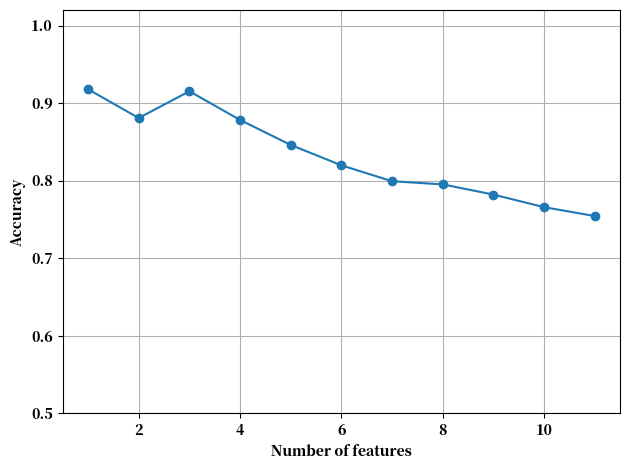

In [404]:
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.5, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()


### 保留'人口密度', '車流量', '經度'進入gridsearchCV訓練

In [27]:
# 建立knn特徵選擇類別
class KnnFeatureSelect():
    def __init__(self):
        self.df = None
        
    def fit(self, X, y=None):
        self.select_list = [4,9,10]
        return self
    
    def transform(self, X):
        self.df = X[:,self.select_list]
        return self.df

In [436]:
# 改寫pipeline
pipe_knn = Pipeline([('log',logData()),
                     ('sc', StandardScaler()),
                     ('pca', DateWeatherPCA()),
                     ('knnSelect', KnnFeatureSelect()),
                     ('knn', KNeighborsClassifier(n_jobs=6))
                      ])

In [437]:
# 待估參數權重的字典
param_grid = {'knn__n_neighbors': np.arange(start=3,stop=26,step=3), 
              'knn__weights': ['uniform', 'distance'],
              'knn__algorithm':['auto'] 
             } 

In [438]:
# 建立GridSearchCV空模
knn_grid = GridSearchCV(estimator=pipe_knn, 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='accuracy', 
                        verbose=10)


knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform
[CV 1/5; 1/16] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform;, score=0.852 total time=  21.6s
[CV 2/5; 1/16] START knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform
[CV 2/5; 1/16] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform;, score=0.893 total time=  18.0s
[CV 3/5; 1/16] START knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform
[CV 3/5; 1/16] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform;, score=0.907 total time=  17.5s
[CV 4/5; 1/16] START knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform
[CV 4/5; 1/16] END knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform;, score=0.903 total time=  17.8s
[CV 5/5; 1/16] START knn__algorithm=auto, knn__n_neighbors=3, knn__weights=uniform
[CV 5/5; 1/16] END knn__algorithm=auto, knn__n_neighbors=3, knn__wei

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        <__main__.logData object at 0x000002804C9DBFD0>),
                                       ('sc', StandardScaler()),
                                       ('pca',
                                        <__main__.DateWeatherPCA object at 0x000002804C9DAE00>),
                                       ('knnSelect',
                                        <__main__.KnnFeatureSelect object at 0x000002804C9D9F60>),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=6))]),
             param_grid={'knn__algorithm': ['auto'],
                         'knn__n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24]),
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

In [440]:
# 結果都藏在實模grid的後面了！
dir(knn_grid)

print('最佳分數: ', knn_grid.best_score_)  
print('最佳參數：', knn_grid.best_params_)
print('最佳模型：', knn_grid.best_estimator_)  

knn_grid_table = pd.DataFrame(knn_grid.cv_results_)
knn_grid_table.to_csv('GridTable_knn.csv')
knn_grid_table

最佳分數:  0.8924358296494546
最佳參數： {'knn__algorithm': 'auto', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
最佳模型： Pipeline(steps=[('log', <__main__.logData object at 0x0000027E80447B20>),
                ('sc', StandardScaler()),
                ('pca', <__main__.DateWeatherPCA object at 0x0000027E80447CA0>),
                ('knnSelect',
                 <__main__.KnnFeatureSelect object at 0x000002803F05E350>),
                ('knn',
                 KNeighborsClassifier(n_jobs=6, n_neighbors=6,
                                      weights='distance'))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.308297,0.195308,9.211564,1.630549,auto,3,uniform,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.852465,0.893123,0.906910,0.902667,0.873151,0.885663,0.020273,9
1,9.165686,0.167396,1.321475,0.091959,auto,3,distance,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.861250,0.897956,0.910495,0.905936,0.879712,0.891070,0.018243,5
2,9.075581,0.021161,8.517814,0.121712,auto,6,uniform,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.837479,0.885552,0.902088,0.896332,0.861630,0.876616,0.023974,11
3,9.750579,0.309238,1.562372,0.072624,auto,6,distance,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.860129,0.899733,0.912764,0.908580,0.880973,0.892436,0.019505,1
4,9.834314,0.164889,8.789088,0.086943,auto,9,uniform,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.838017,0.886315,0.902164,0.897627,0.865965,0.878018,0.023587,10
5,9.583185,0.074554,1.708947,0.028650,auto,9,distance,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.857918,0.899779,0.913286,0.908892,0.880779,0.892131,0.020427,2
6,9.848406,0.134680,9.005458,0.157338,auto,12,uniform,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.831276,0.881816,0.898866,0.894251,0.860192,0.873280,0.024912,13
7,9.900208,0.113961,1.896762,0.068946,auto,12,distance,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.856355,0.899426,0.913140,0.909294,0.880644,0.891772,0.020978,3
8,9.822351,0.244443,9.042442,0.087862,auto,15,uniform,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.832773,0.882343,0.898040,0.893461,0.862827,0.873889,0.023878,12
9,9.784309,0.094946,2.084986,0.071474,auto,15,distance,"{'knn__algorithm': 'auto', 'knn__n_neighbors':...",0.854938,0.899037,0.912879,0.908791,0.880272,0.891183,0.021332,4


In [441]:
y_pred = knn_grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('正確率: ',accuracy)
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))

正確率:  0.786562153961514
混淆矩陣:
 [[242304  47529]
 [ 74868 208754]]


In [444]:
target_names = ['車禍未發生', '車禍發生']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       車禍未發生       0.76      0.84      0.80    289833
        車禍發生       0.81      0.74      0.77    283622

    accuracy                           0.79    573455
   macro avg       0.79      0.79      0.79    573455
weighted avg       0.79      0.79      0.79    573455



In [445]:
modelFileName = "./models/model_best_knn.pkl"

# 儲存模型到文件
with open(modelFileName, "wb") as f:
    pickle.dump(knn_grid.best_estimator_, f)

---

# RFC

In [4]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

In [5]:
pipe_rfc = Pipeline([('log',logData()),
                     ('sc', StandardScaler()),
                     ('rfc', RandomForestClassifier(random_state=42,n_jobs=5))
                      ])

In [6]:
# 待估參數權重的字典
param_grid = {'rfc__n_estimators': [30, 100, 500],
              'rfc__max_features': ['auto', 'sqrt', 'log2'],
              'rfc__max_depth' : [None,10,20],
              'rfc__criterion' :['gini', 'entropy']
}

In [7]:
# 建立GridSearchCV空模
rfc_grid = GridSearchCV(estimator=pipe_rfc, 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='accuracy', 
                        verbose=10,
                        )


rfc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5; 1/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 1/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.467 total time=  56.3s
[CV 2/5; 1/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 1/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.501 total time=  55.7s
[CV 3/5; 1/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 1/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.706 total time=  57.7s
[CV 4/5; 1/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 1/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.542 total time=  55.9s
[CV 5/5; 1/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 1/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.466 total time=  57.0s
[CV 1/5; 2/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 2/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.468 total time= 3.2min
[CV 2/5; 2/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 2/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.501 total time= 3.0min
[CV 3/5; 2/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 2/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.701 total time= 3.0min
[CV 4/5; 2/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 2/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.564 total time= 2.9min
[CV 5/5; 2/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 2/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.464 total time= 2.9min
[CV 1/5; 3/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 3/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.468 total time=14.9min
[CV 2/5; 3/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 3/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.497 total time=15.0min
[CV 3/5; 3/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 3/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.700 total time=15.0min
[CV 4/5; 3/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 3/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.571 total time=14.7min
[CV 5/5; 3/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 3/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.465 total time=14.8min
[CV 1/5; 4/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 4/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.467 total time=  54.9s
[CV 2/5; 4/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 4/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.501 total time=  53.0s
[CV 3/5; 4/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 4/54] END rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.706 total time=  54.5s
[CV 4/5; 4/54] START rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 4/5; 4/

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 10/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.405 total time=  33.9s
[CV 2/5; 10/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 10/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.686 total time=  32.8s
[CV 3/5; 10/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 10/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.788 total time=  33.2s
[CV 4/5; 10/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 10/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.752 total time=  33.1s
[CV 5/5; 10/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 10/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.407 total time=  32.5s
[CV 1/5; 11/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 11/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.398 total time= 1.7min
[CV 2/5; 11/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 11/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.667 total time= 1.7min
[CV 3/5; 11/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 11/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.788 total time= 1.7min
[CV 4/5; 11/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 11/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.745 total time= 1.7min
[CV 5/5; 11/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 11/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.399 total time= 1.7min
[CV 1/5; 12/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 12/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.396 total time= 8.3min
[CV 2/5; 12/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 12/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.664 total time= 8.4min
[CV 3/5; 12/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 12/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.788 total time= 8.5min
[CV 4/5; 12/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 12/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.750 total time= 8.5min
[CV 5/5; 12/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 12/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.398 total time= 8.3min
[CV 1/5; 13/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 13/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.405 total time=  32.4s
[CV 2/5; 13/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 13/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.686 total time=  33.0s
[CV 3/5; 13/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 13/54] END rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.788 total time=  33.1s
[CV 4/5; 13/54] START rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 4/5; 13/54] END

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 19/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.447 total time=  47.4s
[CV 2/5; 19/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 19/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.477 total time=  46.7s
[CV 3/5; 19/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 19/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.751 total time=  48.0s
[CV 4/5; 19/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 19/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.608 total time=  48.1s
[CV 5/5; 19/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 19/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.438 total time=  47.4s
[CV 1/5; 20/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 20/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.444 total time= 2.6min
[CV 2/5; 20/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 20/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.473 total time= 2.5min
[CV 3/5; 20/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 20/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.780 total time= 2.6min
[CV 4/5; 20/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 20/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.615 total time= 2.6min
[CV 5/5; 20/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 20/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.439 total time= 2.6min
[CV 1/5; 21/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 21/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.441 total time=12.4min
[CV 2/5; 21/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 21/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.478 total time=12.3min
[CV 3/5; 21/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 21/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.770 total time=12.6min
[CV 4/5; 21/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 21/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.575 total time=12.5min
[CV 5/5; 21/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 21/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.440 total time=12.3min
[CV 1/5; 22/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 22/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.447 total time=  47.5s
[CV 2/5; 22/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 22/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.477 total time=  46.1s
[CV 3/5; 22/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 22/54] END rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.751 total time=  47.3s
[CV 4/5; 22/54] START rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 4/5; 22/54] END

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 28/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.470 total time=  57.8s
[CV 2/5; 28/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 28/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.508 total time=  56.1s
[CV 3/5; 28/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 28/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.692 total time=  56.3s
[CV 4/5; 28/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 28/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.611 total time=  56.1s
[CV 5/5; 28/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 28/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=30;, score=0.467 total time=  56.6s
[CV 1/5; 29/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 29/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.473 total time= 3.0min
[CV 2/5; 29/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 29/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.513 total time= 3.0min
[CV 3/5; 29/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 29/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.712 total time= 3.1min
[CV 4/5; 29/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 29/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.591 total time= 3.0min
[CV 5/5; 29/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 29/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=100;, score=0.467 total time= 3.1min
[CV 1/5; 30/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 30/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.472 total time=15.3min
[CV 2/5; 30/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 30/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.506 total time=15.3min
[CV 3/5; 30/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 30/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.714 total time=15.6min
[CV 4/5; 30/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 30/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.592 total time=15.4min
[CV 5/5; 30/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 30/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=auto, rfc__n_estimators=500;, score=0.467 total time=15.4min
[CV 1/5; 31/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 31/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.470 total time=  57.6s
[CV 2/5; 31/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 31/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.508 total time=  55.5s
[CV 3/5; 31/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 31/54] END rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.692 total time=  56.6s
[CV 4/5; 31/54] START rfc__criterion=entropy, rfc__max_depth=None, rfc__max_features=sqrt, 

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 37/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.403 total time=  34.4s
[CV 2/5; 37/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 37/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.583 total time=  33.2s
[CV 3/5; 37/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 37/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.788 total time=  34.0s
[CV 4/5; 37/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 37/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.754 total time=  34.0s
[CV 5/5; 37/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 37/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=30;, score=0.400 total time=  32.9s
[CV 1/5; 38/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 38/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.397 total time= 1.7min
[CV 2/5; 38/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 38/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.659 total time= 1.8min
[CV 3/5; 38/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 38/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.787 total time= 1.8min
[CV 4/5; 38/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 38/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.748 total time= 1.8min
[CV 5/5; 38/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 38/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=100;, score=0.399 total time= 1.7min
[CV 1/5; 39/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 39/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.399 total time= 8.5min
[CV 2/5; 39/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 39/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.632 total time= 8.5min
[CV 3/5; 39/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 39/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.784 total time= 8.8min
[CV 4/5; 39/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 39/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.742 total time= 8.7min
[CV 5/5; 39/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 39/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=auto, rfc__n_estimators=500;, score=0.396 total time= 8.5min
[CV 1/5; 40/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 40/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.403 total time=  33.0s
[CV 2/5; 40/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 40/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.583 total time=  33.1s
[CV 3/5; 40/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 40/54] END rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.788 total time=  33.2s
[CV 4/5; 40/54] START rfc__criterion=entropy, rfc__max_depth=10, rfc__max_features=sqrt, rfc__n_estimator

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 46/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.441 total time=  47.9s
[CV 2/5; 46/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 46/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.501 total time=  48.2s
[CV 3/5; 46/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 46/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.767 total time=  49.6s
[CV 4/5; 46/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 46/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.550 total time=  49.1s
[CV 5/5; 46/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 46/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=30;, score=0.440 total time=  48.2s
[CV 1/5; 47/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 47/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.442 total time= 2.6min
[CV 2/5; 47/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 47/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.489 total time= 2.6min
[CV 3/5; 47/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 47/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.761 total time= 2.7min
[CV 4/5; 47/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 47/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.604 total time= 2.6min
[CV 5/5; 47/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 47/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=100;, score=0.441 total time= 2.6min
[CV 1/5; 48/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 48/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.447 total time=12.8min
[CV 2/5; 48/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 48/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.484 total time=12.6min
[CV 3/5; 48/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 48/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.765 total time=13.0min
[CV 4/5; 48/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 48/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.598 total time=12.8min
[CV 5/5; 48/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 48/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=auto, rfc__n_estimators=500;, score=0.440 total time=12.7min
[CV 1/5; 49/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 1/5; 49/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.441 total time=  47.8s
[CV 2/5; 49/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 2/5; 49/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.501 total time=  48.0s
[CV 3/5; 49/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30
[CV 3/5; 49/54] END rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimators=30;, score=0.767 total time=  49.4s
[CV 4/5; 49/54] START rfc__criterion=entropy, rfc__max_depth=20, rfc__max_features=sqrt, rfc__n_estimator

C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        <__main__.logData object at 0x000001FC0171F3D0>),
                                       ('sc', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(n_jobs=5,
                                                               random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [None, 10, 20],
                         'rfc__max_features': ['auto', 'sqrt', 'log2'],
                         'rfc__n_estimators': [30, 100, 500]},
             scoring='accuracy', verbose=10)

In [8]:
# 結果都藏在實模grid的後面了！
dir(rfc_grid)

print('最佳分數: ', rfc_grid.best_score_)  
print('最佳參數：', rfc_grid.best_params_)
print('最佳模型：', rfc_grid.best_estimator_)  

rfc_grid_table = pd.DataFrame(rfc_grid.cv_results_)
rfc_grid_table.to_csv('GridTable_rfc.csv')
rfc_grid_table

最佳分數:  0.6075930599541037
最佳參數： {'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__max_features': 'auto', 'rfc__n_estimators': 30}
最佳模型： Pipeline(steps=[('log', <__main__.logData object at 0x000001FC0171FAC0>),
                ('sc', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=10, max_features='auto',
                                        n_estimators=30, n_jobs=5,
                                        random_state=42))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__criterion,param_rfc__max_depth,param_rfc__max_features,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,55.335672,0.738840,1.294737,0.130835,gini,None,auto,30,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.466523,0.501424,0.705677,0.542312,0.465797,0.536347,0.089197,52
1,175.631700,5.506872,3.837462,0.366426,gini,None,auto,100,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467563,0.500908,0.701056,0.563725,0.464478,0.539546,0.088295,49
2,846.935584,4.577597,46.434847,2.312303,gini,None,auto,500,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467701,0.497279,0.699904,0.571475,0.464870,0.540246,0.088608,43
3,53.002205,0.646054,1.285692,0.091222,gini,None,sqrt,30,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.466523,0.501424,0.705677,0.542312,0.465797,0.536347,0.089197,52
4,170.401685,1.356206,3.680854,0.412894,gini,None,sqrt,100,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467563,0.500908,0.701056,0.563725,0.464478,0.539546,0.088295,49
5,841.482957,9.062980,45.813495,3.782095,gini,None,sqrt,500,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467701,0.497279,0.699904,0.571475,0.464870,0.540246,0.088608,43
6,52.833958,0.762105,1.271670,0.125581,gini,None,log2,30,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.466523,0.501424,0.705677,0.542312,0.465797,0.536347,0.089197,52
7,169.704966,1.477736,3.658786,0.401757,gini,None,log2,100,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467563,0.500908,0.701056,0.563725,0.464478,0.539546,0.088295,49
8,836.016795,10.425382,45.765111,3.783649,gini,None,log2,500,"{'rfc__criterion': 'gini', 'rfc__max_depth': N...",0.467701,0.497279,0.699904,0.571475,0.464870,0.540246,0.088608,43
9,32.700245,0.466356,0.486964,0.014937,gini,10,auto,30,"{'rfc__criterion': 'gini', 'rfc__max_depth': 1...",0.405165,0.685995,0.787988,0.751806,0.407011,0.607593,0.167748,1


In [9]:
y_pred = rfc_grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('正確率: ',accuracy)
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))

正確率:  0.7950336120532562
混淆矩陣:
 [[225597  64236]
 [ 53303 230319]]


In [10]:
target_names = ['車禍未發生', '車禍發生']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       車禍未發生       0.81      0.78      0.79    289833
        車禍發生       0.78      0.81      0.80    283622

    accuracy                           0.80    573455
   macro avg       0.80      0.80      0.80    573455
weighted avg       0.80      0.80      0.80    573455



In [12]:
modelFileName = "./models/model_best_rfc.pkl"

# 儲存模型到文件
with open(modelFileName, "wb") as f:
    pickle.dump(rfc_grid.best_estimator_, f)

---

# XGBoost

In [13]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

In [17]:
pipe_xgb = Pipeline([('log',logData()),
                     ('sc', StandardScaler()),
                     ('xgb', xgb.XGBClassifier(seed=42, tree_method='gpu_hist', gpu_id=0))              
                 ])

In [18]:
# 待估參數權重的字典
param_grid = {
    'xgb__eta':['0.01','0.2','0.3'],
    'xgb__min_child_weight':[1,3],
    'xgb__max_depth': [5, 9, 15],
    "xgb__gamma":[0, 0.25, 0.5, 0.75,1],
    'xgb__n_estimators': [100, 500, 1000],
}

In [19]:
# 建立xgb的GridSearchCV空模
xgb_grid = GridSearchCV(estimator=pipe_xgb , 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='accuracy', 
                        verbose=10)

# xgb_grid變實模
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5; 1/270] START xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100
[CV 1/5; 1/270] END xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100;, score=0.387 total time=   4.6s
[CV 2/5; 1/270] START xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100
[CV 2/5; 1/270] END xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100;, score=0.771 total time=   4.0s
[CV 3/5; 1/270] START xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100
[CV 3/5; 1/270] END xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100;, score=0.789 total time=   4.2s
[CV 4/5; 1/270] START xgb__eta=0.01, xgb__gamma=0, xgb__max_depth=5, xgb__min_child_weight=1, xgb__n_estimators=100
[CV 4/5; 1/270] END xgb__eta=0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('log',
                                        <__main__.logData object at 0x000001FC0331E980>),
                                       ('sc', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=Non...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'xgb__eta': ['0.01', '0.2', '0.3'],
                         'xgb__gamma': [0, 0.25, 0.5, 0.75, 1],
                         'xgb__max_depth': [5, 9, 15],
                         'xgb__min_child_weight': [1, 3],
                         'xgb__n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=10)

In [20]:
# 結果都藏在實模grid的後面了！
dir(xgb_grid)

print('最佳分數: ', xgb_grid.best_score_)  
print('最佳參數：', xgb_grid.best_params_)
print('最佳模型：', xgb_grid.best_estimator_)  

xgb_grid_table = pd.DataFrame(xgb_grid.cv_results_)
xgb_grid_table.to_csv('GridTable_xgb.csv')
xgb_grid_table

最佳分數:  0.6346355458408964
最佳參數： {'xgb__eta': '0.01', 'xgb__gamma': 0.75, 'xgb__max_depth': 15, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100}
最佳模型： Pipeline(steps=[('log', <__main__.logData object at 0x000001FC04B11360>),
                ('sc', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eta='0.01',
                               eval_metric=None, feature_types=None, gamma=0.75,
                               gpu_id=0, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.00999999978, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                             

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__eta,param_xgb__gamma,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.971297,0.209340,0.331399,0.022246,0.01,0,5,1,100,"{'xgb__eta': '0.01', 'xgb__gamma': 0, 'xgb__ma...",0.386696,0.770649,0.789071,0.783864,0.385198,0.623096,0.193725,17
1,9.428427,0.125645,0.644744,0.013246,0.01,0,5,1,500,"{'xgb__eta': '0.01', 'xgb__gamma': 0, 'xgb__ma...",0.392661,0.449857,0.720952,0.426549,0.388925,0.475789,0.124626,257
2,15.640720,0.265669,1.103241,0.084324,0.01,0,5,1,1000,"{'xgb__eta': '0.01', 'xgb__gamma': 0, 'xgb__ma...",0.409369,0.450972,0.581568,0.422766,0.404367,0.453808,0.065899,268
3,3.810001,0.037525,0.320929,0.003694,0.01,0,5,3,100,"{'xgb__eta': '0.01', 'xgb__gamma': 0, 'xgb__ma...",0.386696,0.770360,0.789057,0.784494,0.385198,0.623161,0.193783,12
4,9.245045,0.146173,0.650115,0.007715,0.01,0,5,3,500,"{'xgb__eta': '0.01', 'xgb__gamma': 0, 'xgb__ma...",0.391490,0.446079,0.716589,0.454039,0.389550,0.479550,0.121502,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,11.858259,0.378481,0.493357,0.025466,0.3,1,15,1,500,"{'xgb__eta': '0.3', 'xgb__gamma': 1, 'xgb__max...",0.477641,0.618288,0.714347,0.665724,0.500551,0.595310,0.092175,138
266,15.578405,0.439566,0.563107,0.069563,0.3,1,15,1,1000,"{'xgb__eta': '0.3', 'xgb__gamma': 1, 'xgb__max...",0.477641,0.618288,0.714347,0.665724,0.500551,0.595310,0.092175,138
267,8.303802,0.272698,0.459931,0.010765,0.3,1,15,3,100,"{'xgb__eta': '0.3', 'xgb__gamma': 1, 'xgb__max...",0.482231,0.631042,0.708753,0.683871,0.502114,0.601602,0.093020,92
268,11.106271,0.221750,0.537943,0.100199,0.3,1,15,3,500,"{'xgb__eta': '0.3', 'xgb__gamma': 1, 'xgb__max...",0.482231,0.631042,0.708753,0.683871,0.502114,0.601602,0.093020,92


正確率:  0.8880470132791588


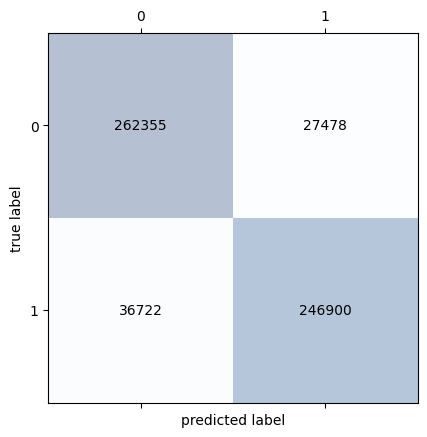

混淆矩陣:
 [[262355  27478]
 [ 36722 246900]]


In [41]:
y_pred = xgb_grid.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confmat = confusion_matrix(y_test, y_pred)
print('正確率: ',accuracy)

fig, ax = plt.subplots()
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()
print('混淆矩陣:\n',confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       車禍未發生       0.88      0.91      0.89    289833
        車禍發生       0.90      0.87      0.88    283622

    accuracy                           0.89    573455
   macro avg       0.89      0.89      0.89    573455
weighted avg       0.89      0.89      0.89    573455



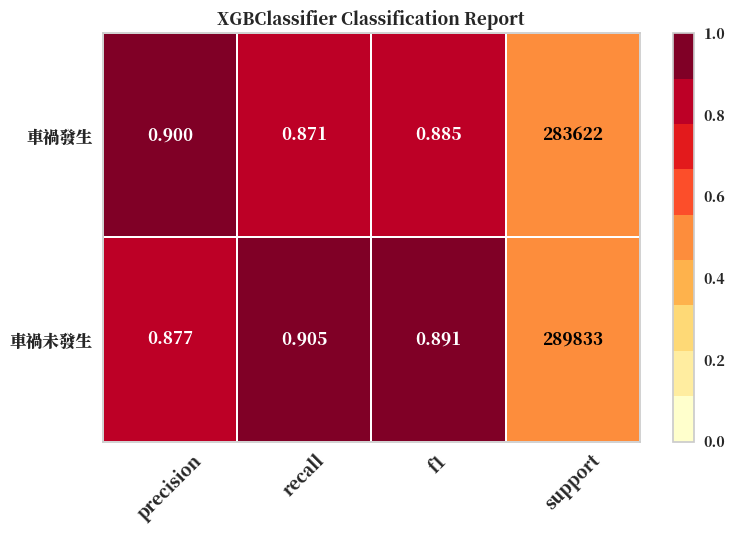

<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>

In [125]:
target_names = ['車禍未發生', '車禍發生']
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)


from yellowbrick.classifier import ClassificationReport

model = xgb_grid.best_estimator_
visualizer = ClassificationReport(model, classes=target_names, support=True)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()   

In [23]:
modelFileName = "./models/model_best_xgb.pkl"

# 儲存模型到文件
with open(modelFileName, "wb") as f:
    pickle.dump(xgb_grid.best_estimator_, f)

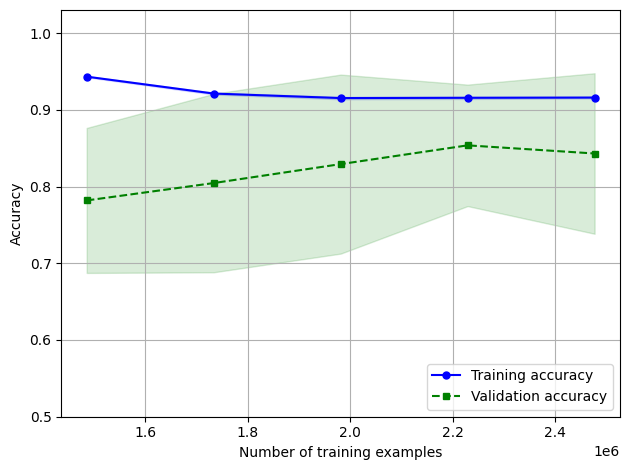

In [45]:
pipe_lr = xgb_grid.best_estimator_

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=6)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

---

# 比較不同類型的模型
diff()函數對不同類模型物件modelDifferences進行推論統計

summary()函數回傳跨模型差異統計的檢定結果

In [28]:
# 載入模型
algorithms = ['logis','knn','rfc','xgb']

models = []

for algorithm in algorithms:
    modelFileName = f"./models/model_best_{algorithm}.pkl"
    with open(modelFileName, "rb") as f:
        model = pickle.load(f)
    models.append((algorithm, model)) # tuple ('簡記名', 建模類別函數全名)

In [29]:
# 載入數據
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

logis: 0.749558 (0.001626)
knn: 0.919375 (0.000811)


C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ben81\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicit

rfc: 0.807089 (0.002866)
xgb: 0.911899 (0.002864)


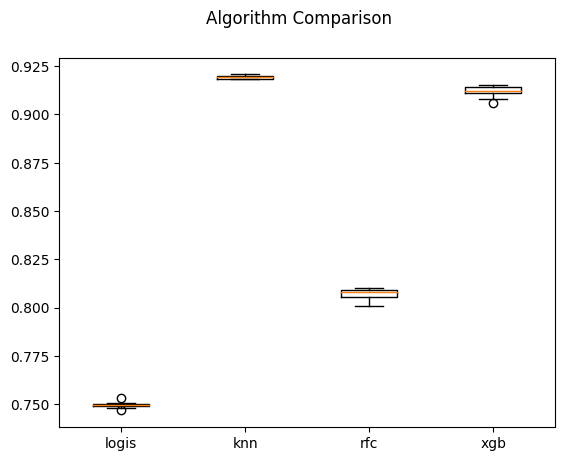

[0.74935335 0.74898688 0.74948945 0.74671814 0.74807137 0.75034342
 0.74983626 0.75318658 0.75075334 0.7488402 ]
[0.91920857 0.9181395  0.92027649 0.91833673 0.9198572  0.91975204
 0.91843417 0.91963333 0.91939231 0.92071568]
[0.80848185 0.81018365 0.80427888 0.80062348 0.80458303 0.80715779
 0.80935996 0.80780414 0.80927032 0.80914683]
[0.90612957 0.91146758 0.90787466 0.91517877 0.91506936 0.91098098
 0.91456073 0.91373749 0.91167612 0.91231433]


In [31]:
#### Reference: How To Compare Machine Learning Algorithms in Python with scikit-learn (https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/)
X, Y = X_test, y_test

# prepare configuration for cross validation test harness
seed = 7

# evaluate each model in turn
results = [] # 逐次添加各模型交叉驗證績效評量結果
names = []
scoring = 'balanced_accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True) # 十摺交叉驗證樣本切分
    # ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

for result in results:
    print(result)

In [33]:

# 可自行完成統計檢定：ANOVA檢定檢視是否有顯著的差異

import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(results[0], results[1], results[2], results[3])

print(fvalue, pvalue)

dfn, dfd = 5, 55
stats.f.sf(fvalue,dfn,dfd)

# P(F>3.7728334504659156)=0.0052222146020425185 (p-value < 0.05)
# Therefore, the hypothesis H0:mean1=mean2=...=mean6 is rejected.
# That is, at least one of these 6 models is better than others.

12498.28516271797 2.307970398348603e-54


1.0669199504703186e-82

In [121]:
pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Eigenvalues 
[2.11591413e+00 2.21872916e-05 7.99290965e-01 1.15712838e+00
 1.08812202e+00 8.89468338e-01 9.22382082e-01 9.83284801e-01
 1.02341326e+00 9.99965555e-01 1.00277988e+00 1.00989085e+00
 1.00834227e+00]


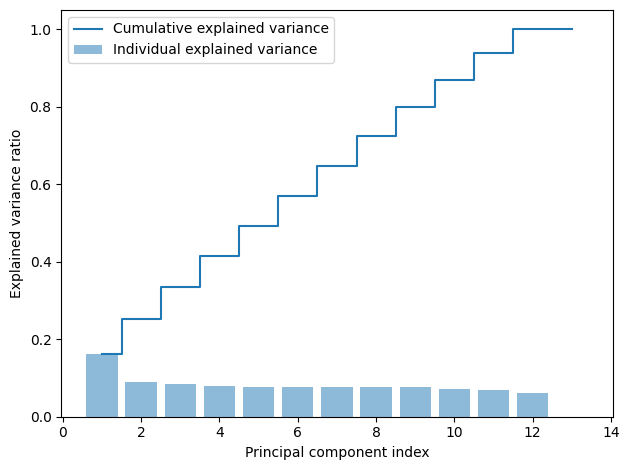

In [119]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train.iloc[:,:13])
X_test_std = sc.transform(X_test.iloc[:,:13])


cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

# KNN

In [126]:
df_pos = pd.read_csv("pos_data(12-26已刪除離群值).csv", encoding='utf-8-sig')
df_neg = pd.read_csv("neg_data(12-26已刪除離群值).csv", encoding='utf-8-sig')

df_neg = df_neg.iloc[:df_pos.shape[0],:]

df = pd.concat([df_pos, df_neg], axis=0)
df2018to2021 = df[df['發生年度']!=2022] 
df2022 = df[df['發生年度']==2022] 

X_train, y_train = df2018to2021.iloc[:,:-1], df2018to2021.iloc[:,-1]
X_test, y_test = df2022.iloc[:,:-1], df2022.iloc[:,-1]

### 循序特徵選擇演算法 SBS (Sequential feature selection algorithms)

In [127]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            print('dim: ',dim)
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### 開始fit SBS KNN

In [128]:
X = X_train.copy()
y = y_train.copy()

X = logData().fit(X).transform(X)
X = StandardScaler().fit_transform(X)
# X = DateWeatherPCA().fit(X).transform(X)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=6)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X, y)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

dim:  23
dim:  22
dim:  21
dim:  20
dim:  19
dim:  18
dim:  17
dim:  16


In [ ]:
sbs.subsets_

In [ ]:
variables = ['時間主成分1','時間主成分2','時間主成分3','時間主成分4','經度','緯度','天氣主成分1','天氣主成分2','天氣主成分3','人口密度','車流量']
preScore = None
preSet = None
for i in range(len(sbs.scores_)):
    score = sbs.scores_[i]
    thisSet = set(sbs.subsets_[i])
    
    improve = f"正確率進步: {score-preScore}" if preScore else "無前一輪"
    deleted = f'本輪刪除({list(preSet - thisSet)[0]}){variables[list(preSet - thisSet)[0]]}' if preSet else "未刪除變數"
    
    print(f'第{i+1}輪訓練--本輪正確率:{score}，{improve}，{deleted}',f'，訓練子集合:{[variables[i] for i in thisSet]}')
    preScore = score
    preSet = thisSet

In [ ]:
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.5, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()

plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()
